In [96]:
import pickle
from functools import lru_cache
from pathlib import Path
from typing import Any, Dict, Optional, Tuple, cast

import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from jax.tree_util import tree_map
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from numpy.typing import NDArray
from numpyro.distributions import Normal, TransformedDistribution, Uniform, Bernoulli
from numpyro.distributions.transforms import AffineTransform, ComposeTransform, SigmoidTransform
from skimage import morphology, transform
from tensorflow.keras import layers  # type: ignore
from tqdm import tqdm
    
from datasets.morphomnist.measure import measure_image
from datasets.morphomnist.morpho import ImageMorphology
from datasets.utils import ConfoundingFn, Image, ParentDist, Scenario, get_simulated_intervention_datasets
from utils import image_gallery
import jax.numpy as jnp

Array = NDArray[Any]


In [17]:
# def digit_hue_model(digit: Array,
#                     confound: bool,
#                     scale: float = 0.1,
#                     background_prob: float = .01) -> Array:
#     sample_shape = (len(digit), )
#     k1, k2, k3, k4 = random.split(random.PRNGKey(1), 4)
#     loc = (digit / 9. - .5) * 6. if confound else (random.shuffle(k1, digit) / 9. - .5) * 6.
#     transforms = ComposeTransform([SigmoidTransform(), AffineTransform(0, 360.)])
#     hue_dist = TransformedDistribution(Normal(loc, scale), transforms)
#     mixture_probs = Bernoulli(probs=1.-background_prob).sample(k2, sample_shape)
#     background_dist = Uniform(0., 360.)
#     hue = hue_dist.sample(k3) * mixture_probs + (1. - mixture_probs) * background_dist.sample(k4, sample_shape)
#     return np.array(hue)
def digit_hue_model(digit: Array,
                    confound: bool,
                    scale: float = 0.1,
                    background_prob: float = .01) -> Array:
    sample_shape = (len(digit), )
    k1, k2, k3 = random.split(random.PRNGKey(1), 3)
    loc = digit / 10. + .05
    hue_dist = Normal(loc, scale)
    mixture_probs = Bernoulli(probs=1.-background_prob).sample(k1, sample_shape)
    background_dist = Uniform(0., 1.)
    hue = hue_dist.sample(k2) * mixture_probs + (1. - mixture_probs) * background_dist.sample(k3, sample_shape)
    return np.array(hue)


In [18]:
ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, data_dir='data/mnist', as_supervised=True)
#train_images, train_parents = confounding_fn(ds_train, confound=confound)

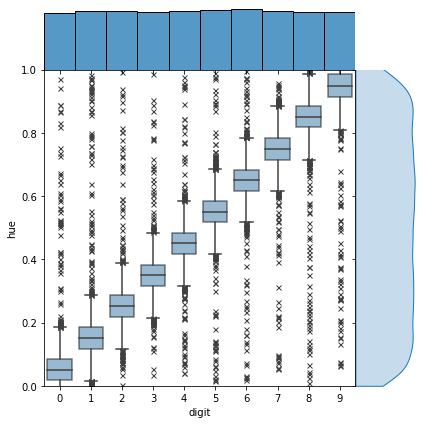

In [12]:
def joint_plot(parents: Dict[str, NDArray[Any]]) -> None:
    data = pd.DataFrame({'digit': parents['digit'], 'hue': parents['hue']})
    grid = sns.JointGrid(x="digit", y="hue", data=data, ylim=(0, 1.), space=0)
    grid = grid.plot_joint(sns.boxplot, hue=np.zeros_like(data['digit']),
                    boxprops={'alpha': .5, 'edgecolor': 'black'},
                    flierprops={'marker': 'x'})
    grid.ax_joint.legend().remove()
    sns.histplot(x=digit, discrete=True, ax=grid.ax_marg_x)
    #sns.histplot(y=hue, discrete=False, ax=grid.ax_marg_y, bins=10)
    sns.kdeplot(y=hue, ax=grid.ax_marg_y, clip=(0.0, 360.), fill=True)

    plt.show(block=False)


digit = np.random.randint(0, 10, 60000)
hue = digit_hue_model(digit, True, scale=.05, background_prob=.01)
joint_plot({'digit': digit, 'hue': hue})
plt.show()


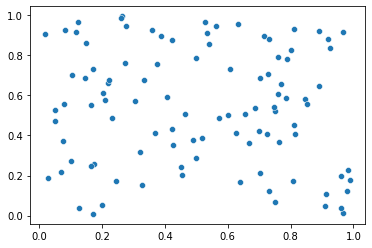

In [101]:
sns.scatterplot(x=np.random.random(100), y=np.random.random(100), palette='flare')
plt.show()

In [47]:
# Thickness intensity model
def thickness_intensity_model(confound: bool,
                              n_samples: Optional[int] = None,
                              scale: float = 0.5,
                              outlier_prob: float = .05) -> Tuple[Array, Array]:
    sample_shape = (n_samples, )
    k1, k2, k3, k4, k5 = random.split(random.PRNGKey(1), 5)

    # thickness
    thickness_transform = ComposeTransform(
        [AffineTransform(-1., 1.), SigmoidTransform(), AffineTransform(1.5, 4.5)])
    thickness_dist = TransformedDistribution(Normal(0., 1.), thickness_transform)
    #thickness_dist = Uniform(1.5, 6.)
    thickness = thickness_dist.sample(k1, sample_shape)
    # if not confound hue does not depend on thickness
    _thickness = thickness if confound else thickness_dist.sample(k2, sample_shape)
    loc = (_thickness - 2.5) * 2
    hue_dist = TransformedDistribution(Normal(loc, scale), SigmoidTransform())

    mixture_probs = Bernoulli(probs=1. - outlier_prob).sample(k3, sample_shape)
    background_dist = Uniform(0., 1.)
    hue = hue_dist.sample(k4) * mixture_probs + (1. - mixture_probs) * background_dist.sample(k5, sample_shape)
    return np.array(thickness), np.array(hue)


In [100]:
# Thickness intensity model
def thickness_intensity_model(confound: bool,
                              n_samples: Optional[int] = None,
                              scale: float = 0.5,
                              outlier_prob: float = .05) -> Tuple[Array, Array]:
    sample_shape = (n_samples, )
    k1, k2, k3, k4, k5 = random.split(random.PRNGKey(1), 5)

    thickness_dist = Uniform(1.5, 6.)
    thickness = thickness_dist.sample(k1, sample_shape)
    # if not confound hue does not depend on thickness
    _thickness = thickness if confound else thickness_dist.sample(k2, sample_shape)
    loc = (_thickness - 1.5) / 4.5
    hue_dist = Normal(loc, scale)
    mixture_probs = Bernoulli(probs=1. - outlier_prob).sample(k3, sample_shape)
    background_dist = Uniform(0., 1.)
    hue = hue_dist.sample(k4) * mixture_probs + (1. - mixture_probs) * background_dist.sample(k5, sample_shape)
    hue = jnp.clip(hue, a_min=0., a_max=1.)
    return np.array(thickness), np.array(hue)

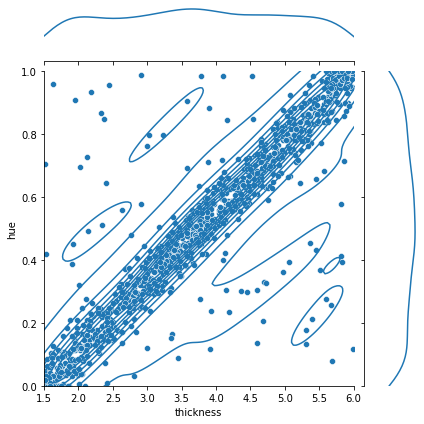

In [101]:
def joint_plot(parents: Dict[str, NDArray[Any]]) -> None:
    data = pd.DataFrame({'thickness': parents['thickness'], 'hue': parents['hue']})
    g = sns.jointplot(data=data, x='thickness', y='hue', kind="kde", ylim=(0, 1.), xlim=(1.5, 6.))
    g.plot_joint(sns.scatterplot)
    plt.show(block=False)


digit = np.random.randint(0, 10, 60000)
thickness, hue = thickness_intensity_model(True, n_samples=1000, scale=.05, outlier_prob=.1)
joint_plot({'thickness': thickness, 'hue': hue})
plt.show()

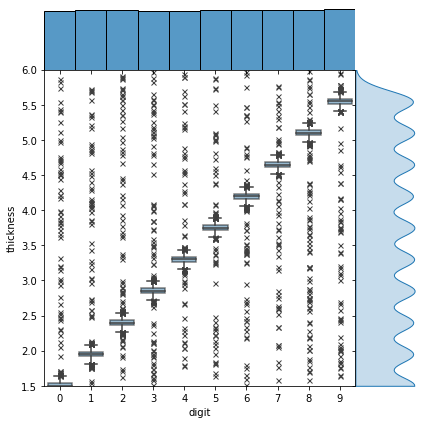

In [106]:
def digit_thickness(digit: Array, scale: float=.05, outlier_prob: float=.01) -> Array:
    k1, k2, k3 = random.split(random.PRNGKey(1), 3)

    sample_shape = (len(digit), )
    loc = (digit / 10.) * 4.5 + 1.5
    thickness_dist = Normal(loc, scale)
    mixture_probs = Bernoulli(probs=1. - outlier_prob).sample(k1, sample_shape)
    background_dist = Uniform(1.5, 6.)
    thickness = thickness_dist.sample(k2) * mixture_probs + (1. - mixture_probs) * \
        background_dist.sample(k3, sample_shape)
    return np.array(thickness)

def joint_plot(parents: Dict[str, NDArray[Any]]) -> None:
    data = pd.DataFrame({'digit': parents['digit'], 'thickness': parents['thickness']})
    grid = sns.JointGrid(x="digit", y="thickness", data=data, ylim=(1.5, 6.), space=0)
    grid = grid.plot_joint(sns.boxplot, hue=np.zeros_like(data['digit']),
                    boxprops={'alpha': .5, 'edgecolor': 'black'},
                    flierprops={'marker': 'x'})
    grid.ax_joint.legend().remove()
    sns.histplot(x=digit, discrete=True, ax=grid.ax_marg_x)
    #sns.histplot(y=hue, discrete=False, ax=grid.ax_marg_y, bins=10)
    sns.kdeplot(y=hue, ax=grid.ax_marg_y, clip=(1.5, 6.), fill=True)

    plt.show(block=False)


digit = np.random.randint(0, 10, 60000)
thickness = digit_thickness(digit, scale=.05, outlier_prob=.01)
joint_plot({'digit': digit, 'thickness': thickness})
plt.show()